# **StepLR Version 4**
# Target:
#### StepLR to decrase the learning rate.
* Added step LR with step size 7 and gamma 0.1
### Results:

* Parameters: 5,893
* Best Train Accuracy: 99.48%
* Best Test Accuracy: 99.07%



**Analysis:**
- Model is having less parameters less than 8000 parameters.
- It is observed that the model is overfitting and there is room for improvement in next version.
- Update model with image augmentation and also updaring step LR params


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

## Data Transformations



In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders



In [4]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The Model Architecture


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # INPUT BLOCK
        # First convolution layer to process input image
        # Input: 28x28x1 | Output: 26x26x7
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),  # Activation function
            nn.BatchNorm2d(num_features=7)  # Normalize the features
        )

        # CONVOLUTION BLOCK 1
        # Increase feature maps and reduce spatial dimensions
        # Input: 26x26x7 | Output: 24x24x14
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14)
        )

        # First pooling layer to reduce spatial dimensions
        # Input: 24x24x14 | Output: 12x12x14
        self.pool1 = nn.MaxPool2d(2, 2)

        # Reduce channels while maintaining spatial information
        # Input: 12x12x14 | Output: 10x10x7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=7)
        )

        # TRANSITION BLOCK 1
        # Note: pool1 is defined twice - this might be a bug in the original code
        # Second pooling operation
        # Input: 10x10x7 | Output: 5x5x7
        self.pool1 = nn.MaxPool2d(2, 2)

        # 1x1 convolution to increase channels without affecting spatial dimensions
        # Input: 5x5x7 | Output: 5x5x14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14)
        )

        # CONVOLUTION BLOCK 2
        # Further feature extraction with increased channels
        # Input: 5x5x14 | Output: 3x3x28
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=28)
        )

        # OUTPUT BLOCK
        # 1x1 convolution to reduce channels to match number of classes
        # Input: 3x3x28 | Output: 3x3x10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10)
        )

        # Global average pooling to reduce spatial dimensions
        # Input: 3x3x10 | Output: 1x1x10
        self.convblock7 = nn.Sequential(
            nn.AvgPool2d(kernel_size=(3,3))
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.convblock1(x)  # Initial feature extraction
        x = self.convblock2(x)  # Increase feature maps
        x = self.pool1(x)       # Reduce spatial dimensions
        x = self.convblock3(x)  # Channel reduction
        x = self.pool1(x)       # Further spatial reduction
        x = self.convblock4(x)  # Channel increase with 1x1 conv
        x = self.convblock5(x)  # Deep feature extraction
        x = self.convblock6(x)  # Reduce to number of classes
        x = self.convblock7(x)  # Global average pooling
        x = x.view(-1, 10)      # Flatten to (batch_size, num_classes)
        return F.log_softmax(x, dim=-1)  # Apply log softmax for classification

# Model Params

In [6]:
!pip install torchsummary

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
              ReLU-2            [-1, 7, 26, 26]               0
       BatchNorm2d-3            [-1, 7, 26, 26]              14
            Conv2d-4           [-1, 14, 24, 24]             882
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
         MaxPool2d-7           [-1, 14, 12, 12]               0
            Conv2d-8            [-1, 7, 10, 10]             882
              ReLU-9            [-1, 7, 10, 10]               0
      BatchNorm2d-10            [-1, 7, 10, 10]              14
        MaxPool2d-11              [-1, 7, 5, 5]               0
           Conv2d-12             [-1, 14, 5, 5]              98
             ReLU-13             [-1, 14, 5, 5]               0
      BatchNorm2d-14             [

# Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model


In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)

    test(model, device, test_loader)

EPOCH: 0


Loss=0.05379306897521019 Batch_id=468 Accuracy=95.10: 100%|██████████| 469/469 [00:36<00:00, 12.72it/s]



Test set: Average loss: 0.0661, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.060438767075538635 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.0449, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.02942151390016079 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:35<00:00, 13.14it/s]



Test set: Average loss: 0.0394, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.018762199208140373 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:34<00:00, 13.61it/s]



Test set: Average loss: 0.0340, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.0719263106584549 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:34<00:00, 13.45it/s]



Test set: Average loss: 0.0337, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.03011627495288849 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s]



Test set: Average loss: 0.0302, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.03821874037384987 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:34<00:00, 13.53it/s]



Test set: Average loss: 0.0328, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.01444909069687128 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s]



Test set: Average loss: 0.0366, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.07248345762491226 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.007146233227103949 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:36<00:00, 13.01it/s]



Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.0405421108007431 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s]



Test set: Average loss: 0.0303, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.002213273663073778 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:34<00:00, 13.52it/s]



Test set: Average loss: 0.0314, Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.015532109886407852 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:34<00:00, 13.54it/s]



Test set: Average loss: 0.0334, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.05172210559248924 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:34<00:00, 13.58it/s]



Test set: Average loss: 0.0310, Accuracy: 9900/10000 (99.00%)

EPOCH: 14


Loss=0.023953689262270927 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99.07%)



Text(0.5, 1.0, 'Test Accuracy')

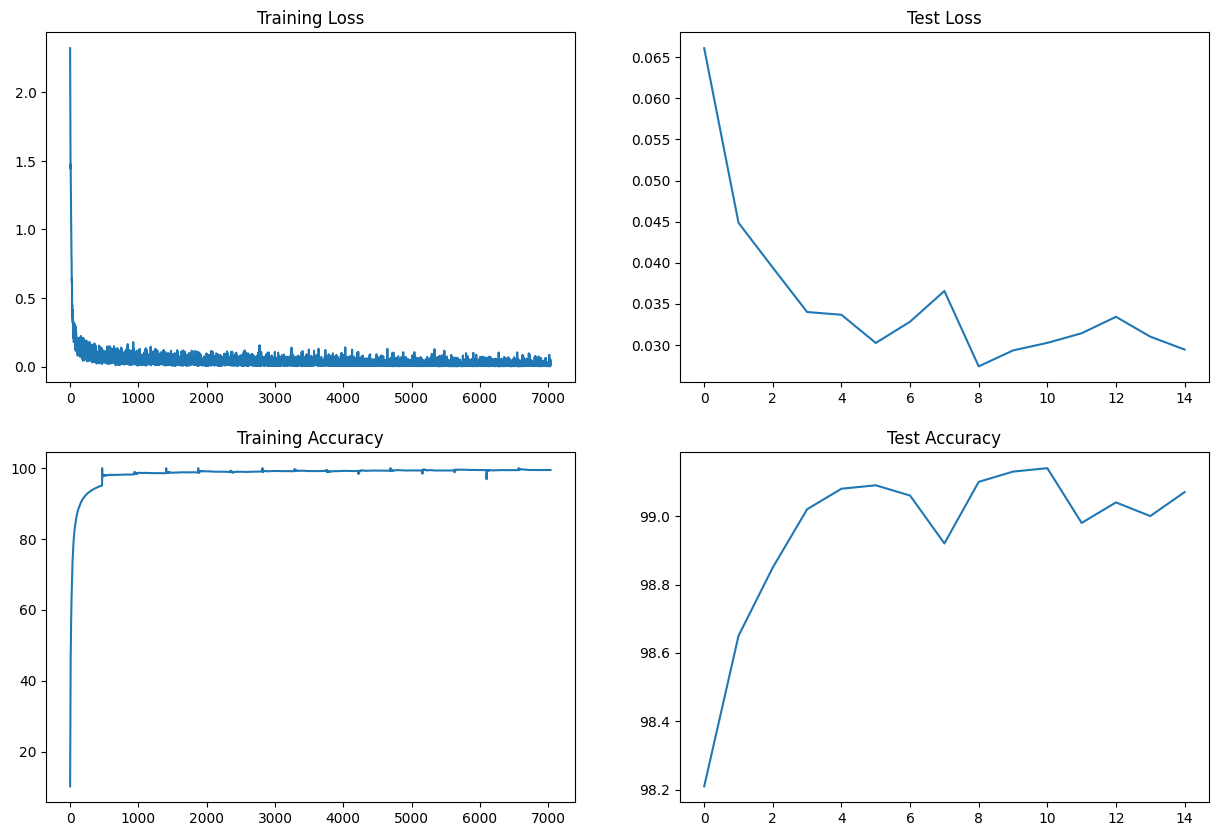

In [12]:
# Commented out IPython magic to ensure Python compatibility.
t = [t_items.item() for t_items in train_losses]
# %matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")